In [58]:
import pandas as pd
import os
import openpyxl
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm, chi2
import matplotlib.pyplot as plt
import pyfolio as pf
from scipy.stats import binom
import math
import numpy.matlib as mt

In [59]:
# Load path
#wd = os.getcwd()
#file = '/Eurostoxx1.xlsx'
#file_path = f"{wd}{file}"
#file_path
# sheet_name = 'Tabelle1'
# # Read the Excel file and skip the first 3 rows and row 5 (row 4 after skipping 3)
# df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=[0, 1, 2, 4])
# df.head(3)

In [60]:
# # Remove any columns with missing values
# df = df.dropna(axis=1)
# # Convert the first column to datetime format and set it as the index
# df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
# df.set_index(df.columns[0], inplace=True)
# # Filter the data to include only dates between 01.01.2018 and 01.01.2024
# start_date = '2018-01-01'
# end_date = '2024-01-01'
# df = df[(df.index >= start_date) & (df.index <= end_date)]
# # Define the public holidays in Germany from 2018 to 2024
# holidays = [
#     '2018-01-01', '2018-03-30', '2018-04-02', '2018-05-10', '2018-05-21', '2018-10-03', '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-31',
#     '2019-01-01', '2019-04-19', '2019-04-22', '2019-05-30', '2019-06-10', '2019-10-03', '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-31',
#     '2020-01-01', '2020-04-10', '2020-04-13', '2020-05-21', '2020-06-01', '2020-10-03', '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-31',
#     '2021-01-01', '2021-04-02', '2021-04-05', '2021-05-13', '2021-05-24', '2021-10-03', '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-31',
#     '2022-01-01', '2022-04-15', '2022-04-18', '2022-05-26', '2022-06-06', '2022-10-03', '2022-12-24', '2022-12-25', '2022-12-26', '2022-12-31',
#     '2023-01-01', '2023-04-07', '2023-04-10', '2023-05-18', '2023-05-29', '2023-10-03', '2023-12-24', '2023-12-25', '2023-12-26', '2023-12-31',
#     '2024-01-01'
# ]

# # Convert holidays to datetime format and remove them from the DataFrame
# holidays = pd.to_datetime(holidays)
# df = df[~df.index.isin(holidays)]

# Save the cleaned data to a CSV file without row numbers
# output_path = '/Users/minhanhle/Documents/MasterArbeit/MasterArbeitCode/Cleaned_Eurostoxx.csv'
# df.to_csv(output_path, index=True)

In [61]:
df = pd.read_csv('./Cleaned_Eurostoxx.csv')
df.rename(columns={'Name': 'Datum'}, inplace=True)
df.columns = [col.replace(' (~E )', '') for col in df.columns]
df.set_index('Datum', inplace=True)
df.head(5)

,3I GROUP,A P MOLLER MAERSK B,A2A,AAK,AALBERTS,ABB LTD N,ABN AMRO BANK,ABRDN,ACCIONA,ACCOR,...,WHITBREAD,WIENERBERGER,WIHLBORGS FASTIGHETER,WOLTERS KLUWER,WORLDLINE,WPP,YARA INTERNATIONAL,ZALANDO (XET),ZEALAND PHARMA,ZURICH INSURANCE GROUP
Datum,,,,,,,,,,,,,,,,,,,,,
2018-01-02,10.36,1235.13,1.522,11.74,42.29,21.526,26.84,4.76,68.46,43.48,...,38.45,20.56,4.97,43.46,40.64,15.07,38.67,43.95,11.90,253.275
2018-01-03,10.37,1228.24,1.516,11.79,42.80,21.714,26.81,4.71,68.80,43.31,...,38.37,20.74,5.03,43.70,41.14,14.64,39.22,45.19,12.34,252.397
2018-01-04,10.48,1264.70,1.570,11.97,43.51,21.909,27.06,4.77,70.40,43.60,...,38.57,21.08,5.02,44.07,41.98,14.80,39.10,45.10,12.54,253.429
2018-01-05,10.63,1273.07,1.593,12.13,44.13,22.131,27.23,4.78,71.14,43.77,...,38.67,20.82,5.04,44.55,41.78,15.09,39.77,45.14,12.32,255.630
2018-01-08,10.43,1307.33,1.591,12.18,44.33,22.227,27.42,4.86,71.06,44.38,...,38.54,20.90,5.12,44.50,42.36,15.07,40.66,45.31,12.35,257.668


In [62]:
# Berechnung der täglichen Rendite
returns = np.log(df/ df.shift(1))
returns.index = df.index
returns.shape

(1517, 564)

In [70]:
# Drop NA
returns = returns.dropna()
#equal weight
equal_weight = np.array([1/len(df.columns)] * len(df.columns))
#weights ae proportional to the prices of the stocks.
prices = returns.mean() * 100
# Portfolio weights proportional to prices
portfolio_weights = prices / prices.sum()
#Wähle Gewichte
weights = equal_weight
#Definiere Sample/Test Set
sampleSize = len(returns)
windowSize = 250
testWindowSize = sampleSize-windowSize
print(testWindowSize)

#V = df[windowSize:len(df)]

1266


In [64]:
# equally weighted pf
portfolio_value = 1000000
historical_returns_pf = (returns * weights).sum(axis=1)
historical_returns_pf
historical_x_day_returns = historical_returns_pf.rolling(window=windowSize).sum()

In [65]:
#tägliche gewichtete Rendite
#V = df[windowSize:len(df)]*weights
#print(V)

            3I GROUP  A P MOLLER MAERSK B       A2A       AAK  AALBERTS  \
Datum                                                                     
2018-12-28  0.015638             1.630035  0.002788  0.021188  0.050230   
2019-01-02  0.015426             1.652057  0.002843  0.021365  0.050337   
2019-01-03  0.015177             1.624167  0.002848  0.021152  0.048794   
2019-01-04  0.015904             1.710957  0.002891  0.021560  0.051082   
2019-01-07  0.015851             1.734876  0.002895  0.021507  0.051099   
...              ...                  ...       ...       ...       ...   
2023-12-21  0.049344             2.846560  0.003301  0.035940  0.069681   
2023-12-22  0.049557             2.925656  0.003296  0.036206  0.070089   
2023-12-27  0.049858             2.789592  0.003280  0.036117  0.070053   
2023-12-28  0.049681             2.742145  0.003286  0.036365  0.069716   
2023-12-29  0.049539             2.778387  0.003296  0.035798  0.069610   

            ABB LTD N  A

In [66]:
returns.shape

(1516, 564)

In [93]:
#VaR Konfidenzniveau
pVaR = 0.999
#Get Zscores for alpha value
zScore = norm.ppf(pVaR)
print(zScore)
#Definiere VaR-Vektoren
normalVaR = np.zeros(testWindowSize)
shrinkageVaR = np.zeros(testWindowSize)

#Definiere Delta 
delta = np.ones(564)

3.090232306167813


In [80]:
print(norm.ppf(0.05))

-1.6448536269514729


***Shrinkage + CCM***


In [138]:
Y = pd.read_csv('output_return1.csv')
Y = Y.drop(columns=['Datum'])
N,p = Y.shape    
n = N-k   
sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n
print(sample)

          0         1         2         3         4         5         6    \
0    0.000243  0.000087  0.000051  0.000050  0.000114  0.000108  0.000079   
1    0.000087  0.000472  0.000047  0.000061  0.000117  0.000117  0.000104   
2    0.000051  0.000047  0.000195  0.000040  0.000040  0.000051  0.000040   
3    0.000050  0.000061  0.000040  0.000162  0.000075  0.000058  0.000030   
4    0.000114  0.000117  0.000040  0.000075  0.000190  0.000117  0.000069   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.000102  0.000105  0.000060  0.000081  0.000076  0.000113  0.000079   
560  0.000080  0.000124  0.000044  0.000060  0.000102  0.000110  0.000083   
561  0.000085  0.000033  0.000022  0.000066  0.000090  0.000093  0.000065   
562  0.000109  0.000107  0.000059  0.000060  0.000073  0.000093  0.000060   
563  0.000079  0.000063  0.000040  0.000034  0.000061  0.000074  0.000062   

          7         8         9    ...       554       555       556  \
0  

In [134]:
cov = np.cov(Y, rowvar=False)
print(cov)

[[2.43733654e-04 8.61934702e-05 5.09728309e-05 ... 8.31769930e-05
  1.09396289e-04 7.96500036e-05]
 [8.61934702e-05 4.72781782e-04 4.75342635e-05 ... 2.94883142e-05
  1.07052409e-04 6.37422779e-05]
 [5.09728309e-05 4.75342635e-05 1.95754726e-04 ... 2.19921890e-05
  5.91529697e-05 4.04269969e-05]
 ...
 [8.31769930e-05 2.94883142e-05 2.19921890e-05 ... 5.18071109e-04
  1.03012723e-04 5.84319652e-05]
 [1.09396289e-04 1.07052409e-04 5.91529697e-05 ... 1.03012723e-04
  5.88617255e-04 6.03829650e-05]
 [7.96500036e-05 6.37422779e-05 4.04269969e-05 ... 5.84319652e-05
  6.03829650e-05 9.91316479e-05]]


In [139]:
def covCor(Y,k = None):
    
    #Pre-Conditions: Y is a valid pd.dataframe and optional arg- k which can be
    #    None, np.nan or int
    #Post-Condition: Sigmahat dataframe is returned
    
    # de-mean returns if required
    N,p = Y.shape                      # sample size and matrix dimension
   
   
    #default setting
    if k is None or math.isnan(k):
        
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1

    #vars
    n = N-k                                    # adjust effective sample size

    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    
    # compute shrinkage target
    samplevar = np.diag(sample.to_numpy())
    sqrtvar = pd.DataFrame(np.sqrt(samplevar))
    rBar = (np.sum(np.sum(sample.to_numpy()/np.matmul(sqrtvar.to_numpy(),sqrtvar.T.to_numpy())))-p)/(p*(p-1)) # mean correlation
    target = pd.DataFrame(rBar*np.matmul(sqrtvar.to_numpy(),sqrtvar.T.to_numpy()))
    target[np.logical_and(np.eye(p),np.eye(p))] = sample[np.logical_and(np.eye(p),np.eye(p))];
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    pihat = sum(piMat.sum())
    
    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    
    # diagonal part of the parameter that we call rho 
    rho_diag =  np.sum(np.diag(piMat))
    
    # off-diagonal part of the parameter that we call rho 
    term1 = pd.DataFrame(np.matmul((Y**3).T.to_numpy(),Y.to_numpy())/n)
    term2 = pd.DataFrame(np.transpose(mt.repmat(samplevar,p,1))*sample)
    thetaMat = term1-term2
    thetaMat[np.logical_and(np.eye(p),np.eye(p))] = pd.DataFrame(np.zeros((p,p)))[np.logical_and(np.eye(p),np.eye(p))]
    rho_off = rBar*(np.matmul((1/sqrtvar).to_numpy(),sqrtvar.T.to_numpy())*thetaMat).sum().sum()
    
    # compute shrinkage intensity
    rhohat = rho_diag + rho_off
    kappahat = (pihat - rhohat) / gammahat
    shrinkage = max(0 , min(1 , kappahat/n))
    
    # compute shrinkage estimator
    sigmahat = shrinkage*target + (1-shrinkage) * sample;
    
    return sigmahat



In [68]:
# returnsData = returns[0:250].reset_index(drop=True)
# covMatrix = np.cov(returnsData, rowvar=False)
# returnsData_iklindex = returns[0:250]
# returnsData_iklindex.to_csv('output_return1.csv')
#print(covMatrix.shape)
# v1 = V.iloc[0, :].reset_index(drop=True)
# #v= v1
# v= weights
# v_trans = v.T
# sigma = np.sqrt(v_trans@covMatrix@v*250)
# print(sigma)

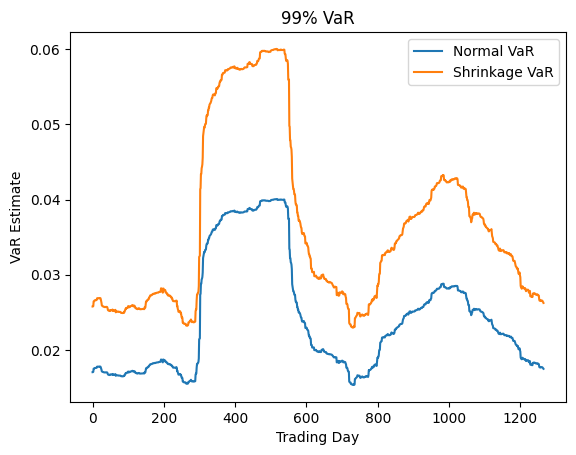

In [140]:
normalPortfolioSigmas = pd.DataFrame()
daily_normalVaR = pd.DataFrame()
normalVaR_250 = pd.DataFrame()
daily_shrinkageVaR = pd.DataFrame()
shrinkageVaR_250 = pd.DataFrame()
portfolioGewinnVerlust = pd.DataFrame()
rolling_250day_returns = pd.DataFrame()
rolling_daily_returns = pd.DataFrame()
for t in range(testWindowSize):
    k = windowSize + t

    # Berechnen der Kovarianzmatrix
    df_test = df[t:k]
    returnsData = returns[t:k].reset_index(drop=True)
    
    sample_cov = pd.DataFrame(np.matmul(returnsData.T.to_numpy(),returnsData.to_numpy()))/563
    popular_cov = np.cov(returnsData, rowvar=False)
    covMatrix = sample_cov
    shrinkage_cov = covCor(returnsData)
    #print(shrinkage_cov.shape)
    # Calculate the expected daily return
    expected_daily_return = returnsData.mean().dot(weights)

    # Calculate the expected return over 250 days
    expected_250day_return = expected_daily_return * 250

    # Berechnen der Standardabweichung der Portfolio-Renditen
    #v1 = V.iloc[t, :].reset_index(drop=True)
    #v= v1
    v= weights
    v_trans = v.T
    
    # Berechne Stichproben-VKM sigma 
    sigma = np.sqrt(v_trans@covMatrix@v)
    normalPortfolioSigmas.loc[t,'Sigma'] = sigma
    # Berechne Shrinkage-VKA
    sigmahat = np.sqrt(v_trans@shrinkage_cov@v)
    #print(sigmahat.shape)
    # Speichere der täglicher VaR mit normalen VKM
    daily_normalVaR.loc[t,'GV'] = zScore * sigma 
    daily_shrinkageVaR.loc[t,'GV'] = zScore * sigmahat 
    # Speichere der 250day_VaR
    normalVaR_250.loc[t,'GV'] = zScore * sigma * np.sqrt(250) - expected_250day_return
    shrinkageVaR_250.loc[t,'GV'] = zScore * sigmahat * np.sqrt(250) - expected_250day_return
    # Speichere die Gewinn-Verlust-Werte
    #portfolioGewinnVerlust.loc[t,'GV'] = np.sum(returns.iloc[k, :] * v1)
    rolling_daily_returns.loc[t,'GV'] = np.sum(returns.iloc[k, :]*weights)
#Plotten der VaR-Werte
plt.plot()
plt.plot(range(0, testWindowSize), daily_normalVaR, label='Normal VaR')
plt.plot(range(0, testWindowSize), daily_shrinkageVaR, label='Shrinkage VaR')
plt.xlabel('Trading Day')
plt.ylabel('VaR Estimate')
plt.title('99% VaR')
plt.legend()
plt.show()
#TODO: x-Achse die Datum angezeigen werden.

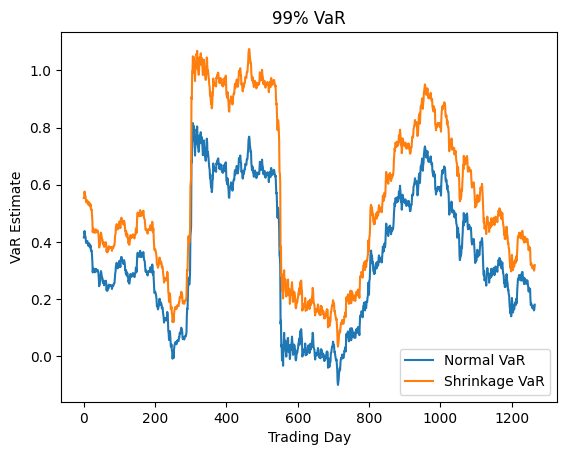

In [145]:
#Plotten der VaR-Werte
plt.plot()
plt.plot(range(0, testWindowSize), normalVaR_250, label='Normal VaR')
plt.plot(range(0, testWindowSize), shrinkageVaR_250, label='Shrinkage VaR')
plt.xlabel('Trading Day')
plt.ylabel('VaR Estimate')
plt.title('99% VaR')
plt.legend()
plt.show()

***Backtesting***

In [153]:
from scipy.stats import binom, chi2, kstest

In [154]:
failure_normal = rolling_daily_returns['GV'] <  - daily_normalVaR['GV']
# failure_normal_pos = daily_normalVaR[failure_normal].index
# print(failure_normal_pos)
print(rolling_daily_returns[failure_normal])
print(-daily_normalVaR[failure_normal])
print(-daily_shrinkageVaR[failure_normal])
failure_shrinkage = rolling_daily_returns['GV'] <  - daily_shrinkageVaR['GV']
# failure_normal_pos = daily_normalVaR[failure_normal].index
# print(failure_normal_pos)
print(failure_shrinkage.sum())


            GV
89   -0.017079
145  -0.017717
148  -0.023267
149  -0.024903
156  -0.019493
191  -0.026184
268  -0.022170
288  -0.040934
289  -0.017672
291  -0.039977
292  -0.032604
296  -0.018860
297  -0.033410
298  -0.078328
301  -0.130253
303  -0.066944
305  -0.045536
308  -0.046473
312  -0.035333
323  -0.042443
362  -0.045598
434  -0.038734
641  -0.024924
692  -0.022926
735  -0.038202
773  -0.021587
774  -0.039557
789  -0.019819
797  -0.034278
800  -0.027741
802  -0.022699
803  -0.038426
847  -0.032017
869  -0.029565
870  -0.030233
873  -0.029067
944  -0.026957
1063 -0.025475
1065 -0.031660
1142 -0.023500
            GV
89   -0.016567
145  -0.016889
148  -0.017026
149  -0.017279
156  -0.017724
191  -0.018464
268  -0.015567
288  -0.015865
289  -0.016732
291  -0.016875
292  -0.017658
296  -0.018299
297  -0.018430
298  -0.018885
301  -0.021548
303  -0.027464
305  -0.028804
308  -0.029701
312  -0.032713
323  -0.034184
362  -0.037345
434  -0.038431
641  -0.019738
692  -0.018299
735  -0.01

In [155]:
# Define backtesting functions
def kupiec_pof_test(portfolio_returns, var_estimates, confidence_level):
    exceptions = portfolio_returns < -var_estimates
    num_exceptions = np.sum(exceptions)
    num_days = len(portfolio_returns)
    expected_exceptions = num_days * (1 - confidence_level)
    p_value = 1 - binom.cdf(num_exceptions, num_days, 1 - confidence_level)
    return num_exceptions, expected_exceptions, p_value

def christoffersen_cc_test(portfolio_returns, var_estimates, confidence_level):
    exceptions = portfolio_returns < -var_estimates
    num_exceptions = np.sum(exceptions)
    num_days = len(portfolio_returns)
    expected_exceptions = num_days * (1 - confidence_level)
    transition_matrix = np.zeros((2, 2))
    for i in range(1, len(exceptions)):
        transition_matrix[exceptions[i - 1], exceptions[i]] += 1
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
    p_independence = (transition_matrix[0, 1] * transition_matrix[1, 0]) / (
            (1 - transition_matrix[0, 0]) * (1 - transition_matrix[1, 1]))
    lr_independence = -2 * np.log(p_independence)
    p_value = 1 - chi2.cdf(lr_independence, df=1)
    return num_exceptions, expected_exceptions, p_value

def tbf_test(portfolio_returns, var_estimates):
    exceptions = portfolio_returns < -var_estimates
    exception_indices = np.where(exceptions)[0]
    time_between_failures = np.diff(exception_indices)
    if len(time_between_failures) > 1:
        scale = np.mean(time_between_failures)
        _, p_value = kstest(time_between_failures, 'expon', args=(0, scale))
    else:
        p_value = 1  # Not enough data to perform the test
    return time_between_failures, p_value

def likelihood_ratio_test(portfolio_returns, var_estimates, confidence_level):
    exceptions = portfolio_returns < -var_estimates
    num_exceptions = np.sum(exceptions)
    num_days = len(portfolio_returns)
    expected_exceptions = num_days * (1 - confidence_level)
    likelihood_model = (confidence_level ** (num_days - num_exceptions)) * ((1 - confidence_level) ** num_exceptions)
    likelihood_null = (num_exceptions / num_days) ** num_exceptions * ((num_days - num_exceptions) / num_days) ** (
            num_days - num_exceptions)
    lr_stat = -2 * np.log(likelihood_model / likelihood_null)
    p_value = 1 - chi2.cdf(lr_stat, df=1)
    return num_exceptions, expected_exceptions, p_value

# Assuming df, returns, weights, zScore, testWindowSize, and windowSize are already defined


In [157]:
# Perform backtesting-NormalVaR
confidence_level = 0.99

# Kupiec's Proportion of Failures (POF) Test
num_exceptions, expected_exceptions, p_value_pof = kupiec_pof_test(rolling_daily_returns['GV'], daily_normalVaR['GV'], confidence_level)
print(f'Kupiec POF Test - Number of exceptions: {num_exceptions}, Expected exceptions: {expected_exceptions}, P-value: {p_value_pof}')

# Christoffersen's Conditional Coverage (CC) Test
num_exceptions, expected_exceptions, p_value_cc = christoffersen_cc_test(rolling_daily_returns['GV'], daily_normalVaR['GV'], confidence_level)
print(f'Christoffersen CC Test - Number of exceptions: {num_exceptions}, Expected exceptions: {expected_exceptions}, P-value: {p_value_cc}')

# Time Between Failures (TBF) Test
time_between_failures, p_value_tbf = tbf_test(rolling_daily_returns['GV'], daily_normalVaR['GV'])
print(f'Time Between Failures Test - Time between failures: {time_between_failures}, P-value: {p_value_tbf}')

# Likelihood Ratio Test
num_exceptions, expected_exceptions, p_value_lr = likelihood_ratio_test(rolling_daily_returns['GV'], daily_normalVaR['GV'], confidence_level)
print(f'Likelihood Ratio Test - Number of exceptions: {num_exceptions}, Expected exceptions: {expected_exceptions}, P-value: {p_value_lr}')

Kupiec POF Test - Number of exceptions: 40, Expected exceptions: 12.66000000000001, P-value: 1.5629808558514924e-10
Christoffersen CC Test - Number of exceptions: 40, Expected exceptions: 12.66000000000001, P-value: 1.0
Time Between Failures Test - Time between failures: [ 56   3   1   7  35  77  20   1   2   1   4   1   1   3   2   2   3   4
  11  39  72 207  51  43  38   1  15   8   3   2   1  44  22   1   3  71
 119   2  77], P-value: 1.9459098143476298e-05
Likelihood Ratio Test - Number of exceptions: 40, Expected exceptions: 12.66000000000001, P-value: 7.238289967403944e-10


In [158]:
# Perform backtesting-Shrinkage VaR
confidence_level = 0.99

# Kupiec's Proportion of Failures (POF) Test
num_exceptions, expected_exceptions, p_value_pof = kupiec_pof_test(rolling_daily_returns['GV'], daily_shrinkageVaR['GV'], confidence_level)
print(f'Kupiec POF Test - Number of exceptions: {num_exceptions}, Expected exceptions: {expected_exceptions}, P-value: {p_value_pof}')

# Christoffersen's Conditional Coverage (CC) Test
num_exceptions, expected_exceptions, p_value_cc = christoffersen_cc_test(rolling_daily_returns['GV'], daily_shrinkageVaR['GV'], confidence_level)
print(f'Christoffersen CC Test - Number of exceptions: {num_exceptions}, Expected exceptions: {expected_exceptions}, P-value: {p_value_cc}')

# Time Between Failures (TBF) Test
time_between_failures, p_value_tbf = tbf_test(rolling_daily_returns['GV'], daily_shrinkageVaR['GV'])
print(f'Time Between Failures Test - Time between failures: {time_between_failures}, P-value: {p_value_tbf}')

# Likelihood Ratio Test
num_exceptions, expected_exceptions, p_value_lr = likelihood_ratio_test(rolling_daily_returns['GV'], daily_shrinkageVaR['GV'], confidence_level)
print(f'Likelihood Ratio Test - Number of exceptions: {num_exceptions}, Expected exceptions: {expected_exceptions}, P-value: {p_value_lr}')

Kupiec POF Test - Number of exceptions: 13, Expected exceptions: 12.66000000000001, P-value: 0.3894435532314987
Christoffersen CC Test - Number of exceptions: 13, Expected exceptions: 12.66000000000001, P-value: 1.0
Time Between Failures Test - Time between failures: [  3   1   5   1   3   2   2   3 427  39  23   6], P-value: 5.721432276123862e-05
Likelihood Ratio Test - Number of exceptions: 13, Expected exceptions: 12.66000000000001, P-value: 0.9238243867841989
